# Federated Learning for Bearing Anomaly Detection with Flower 🌸

This notebook demonstrates federated learning using Flower (flwr) framework with PyTorch to train an autoencoder model on bearing sensor data. The autoencoder learns to reconstruct normal bearing behavior, which can be used for anomaly detection.

## 📋 Table of Contents
1. **Setup & Installation** - Install dependencies
2. **Data Preparation** - Load and prepare bearing sensor data
   - Understanding data structure
   - Input/Output examples
   - Data statistics and visualization
3. **Model Definition** - Define the autoencoder architecture
4. **Dataset Class** - Create PyTorch dataset for autoencoder
5. **Data Loading Functions** - Partition data for federated learning
6. **Training & Testing Functions** - Define training and evaluation logic
7. **Flower Client Definition** - Define federated learning client
8. **Flower Server Strategy** - Define server aggregation strategy
9. **Run Federated Learning Simulation** - Execute FL training
10. **Evaluate Final Model** - Test the global model
11. **Visualize Results** - Plot training metrics and reconstructions
    - Loss and RMSE plots
    - Accuracy metrics and improvements
    - Reconstruction quality analysis
    - Input → Output testing with examples
12. **Save Final Model** - Export trained model
13. **Summary & Next Steps** - Key insights and future directions

## 📖 Project Overview

This notebook demonstrates **Federated Learning for Bearing Anomaly Detection** using an Autoencoder architecture.

### **What We'll Build:**
1. **Autoencoder Model** 🧠
   - Input: 8 sensor readings from bearing vibration data
   - Architecture: Encoder (8 → 4 → 2) + Decoder (2 → 4 → 8)
   - Purpose: Learn normal bearing patterns and detect anomalies

2. **Federated Learning with Flower** 🌸
   - Multiple clients (simulating edge devices)
   - Collaborative training without sharing raw data
   - Privacy-preserving machine learning

3. **Two Key Experiments** 🔬
   - **Experiment 1**: FedAvg with **balanced data** (IID) - Baseline
   - **Experiment 2**: FedAvg with **imbalanced data** (Non-IID) - Real-world scenario

### **Key Research Questions:**
- ❓ How does data distribution affect federated learning?
- ❓ Does imbalanced data degrade FedAvg performance?

### **Technology Stack:**
- **PyTorch**: Deep learning framework
- **Flower**: Federated learning framework
- **Pandas**: Data manipulation
- **Matplotlib**: Visualization

### **Dataset:**
- **NASA IMS Bearing Dataset** (vibration sensor data)
- 8 channels of vibration measurements
- Multiple bearing failures recorded over time
- Perfect for demonstrating edge device scenarios

### **Why This Matters:**
In real-world Industrial IoT:
- 🏭 Different factories collect different amounts of data
- 📊 Data distribution is naturally imbalanced
- 🔒 Data privacy regulations prevent centralized collection
- 🌐 Federated learning enables collaborative model training

Let's explore how different data distributions affect federated learning performance!

## 1. Setup & Installation 📦

Install all required dependencies for Flower federated learning with simulation support.

In [1]:
# Install dependencies
%pip install  "flwr[simulation]>=1.23.0"
%pip install  torch torchvision
%pip install  pandas numpy matplotlib scikit-learn
%pip install "ray>=2.10.0"

print("✅ All dependencies installed successfully!")
import ray
import logging
import os

# Tắt log Ray
os.environ["RAY_LOG_TO_STDERR"] = "0"
os.environ["RAY_BACKEND_LOG_LEVEL"] = "ERROR"
os.environ["RAY_LOG_LEVEL"] = "ERROR"

# Khởi tạo Ray
ray.init(ignore_reinit_error=True, log_to_driver=False)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
✅ All dependencies installed successfully!
Note: you may need to restart the kernel to use updated packages.
✅ All dependencies installed successfully!


/Users/mac/Downloads/flwr-demo/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-21 10:48:27,194	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-11-21 10:48:28,067	INFO worker.py:2012 -- Started a local Ray instance.
2025-11-21 10:48:28,067	INFO worker.py:2012 -- Started a local Ray instance.
[2025-11-21 10:48:28,072 I 78269 5079016] logging.cc:303: Set ray log level from environment variable RAY_BACKEND_LOG_LEVEL to 2
/Users/mac/Downloads/flwr-demo/.venv/lib/python3.13/site-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and 

Python version:,3.13.4
Ray version:,2.51.1


In [2]:
# Import necessary libraries
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
from collections import OrderedDict

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import flwr as fl
from flwr.common import Context, Metrics, NDArrays, Scalar
from flwr.server.strategy import FedAvg
from flwr.simulation import start_simulation

print(f"PyTorch version: {torch.__version__}")
print(f"Flower version: {fl.__version__}")
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

PyTorch version: 2.7.1
Flower version: 1.23.0
Device: cpu


## 2. Data Preparation 📊

### Understanding the Data Structure

**What is Bearing Sensor Data?**
- Bearings are mechanical components that reduce friction between moving parts
- Sensor data captures vibration patterns from 4 bearings (B1, B2, B3, B4)
- Each bearing has 2 sensors (a, b) measuring different vibration directions
- **Total: 8 sensor readings per time step**

**Data Structure:**
```
Time  | B1_a | B1_b | B2_a | B2_b | B3_a | B3_b | B4_a | B4_b
------|------|------|------|------|------|------|------|------
  1   | 0.12 | 0.15 | 0.11 | 0.13 | 0.14 | 0.12 | 0.10 | 0.13
  2   | 0.13 | 0.14 | 0.12 | 0.14 | 0.13 | 0.11 | 0.11 | 0.12
  3   | 0.11 | 0.16 | 0.10 | 0.12 | 0.15 | 0.13 | 0.12 | 0.14
 ...  | ...  | ...  | ...  | ...  | ...  | ...  | ...  | ...
```

**Input → Output Goal:**
- **Input**: 8-dimensional vector [B1_a, B1_b, B2_a, B2_b, B3_a, B3_b, B4_a, B4_b]
- **Output**: Reconstructed 8-dimensional vector (same as input)
- **Purpose**: Autoencoder learns to compress and reconstruct normal patterns
  - ✅ **Normal bearing**: Low reconstruction error (good reconstruction)
  - ❌ **Faulty bearing**: High reconstruction error (poor reconstruction)

**Federated Learning Setup:**
- Data is split across **10 clients** (simulating distributed organizations)
- Each client trains on their local data partition
- Model updates are aggregated on server without sharing raw data
- **Privacy preserved**: Only model parameters are shared, not sensor data

### Data Loading Options

This section handles data loading with **four options** (in order of priority):

1. 🌐 **Download from GitHub**: Automatically download dataset from repository
2. 📤 **Google Colab Upload**: Upload your `bearing_merged_*.csv` file
3. 💾 **Local Environment**: Load from `processed/bearing_merged_*.csv`
4. 🔄 **Fallback**: Create synthetic bearing data for demonstration


💾 Option 1: Loading from Local Directory
✅ Found local data file: processed/bearing_merged_2.csv

📊 DATA LOADING SUMMARY
✅ Using data file: processed/bearing_merged_2.csv
✅ Data loaded successfully: 40960 rows, 8 columns
📊 DATA VISUALIZATION

Sensor columns: ['B1_a', 'B1_b', 'B2_a', 'B2_b', 'B3_a', 'B3_b', 'B4_a', 'B4_b']
Total samples: 40960

📋 First 5 samples:
    B1_a   B1_b   B2_a   B2_b   B3_a   B3_b   B4_a   B4_b
0 -0.054 -0.049 -0.208 -0.081 -0.122 -0.222 -0.085 -0.129
1 -0.215 -0.044 -0.151 -0.149 -0.244 -0.142 -0.059 -0.146
2 -0.242 -0.112 -0.081 -0.178 -0.156 -0.103 -0.137 -0.078
3 -0.164 -0.032 -0.222 -0.117 -0.076 -0.149 -0.166 -0.081
4 -0.098 -0.117 -0.349 -0.125  0.046 -0.129 -0.063 -0.044

📈 Statistical Summary:
               B1_a          B1_b          B2_a          B2_b          B3_a  \
count  40960.000000  40960.000000  40960.000000  40960.000000  40960.000000   
mean      -0.095900     -0.095585     -0.095995     -0.096274     -0.093455   
std        0.080523      

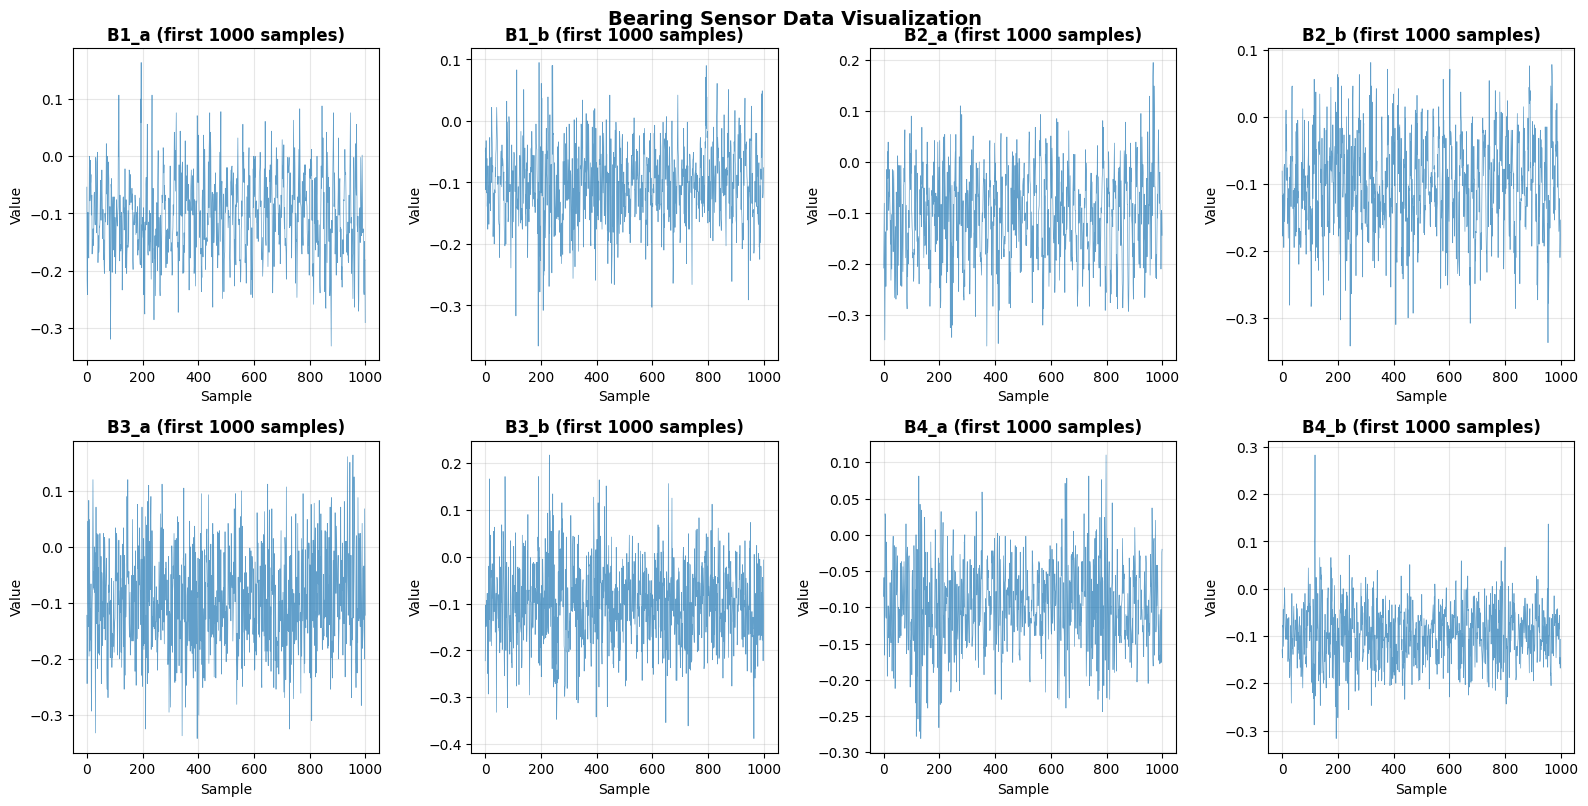


✅ Data loaded and visualized successfully!


In [25]:
# Data Loading with Multiple Options
import urllib.request

csv_filename = None


# Option 1: Try to load from local directory (if not downloaded/uploaded)
if csv_filename is None:
    print("\n" + "="*60)
    print("💾 Option 1: Loading from Local Directory")
    print("="*60)

    local_paths = [
        # "processed/bearing_synthetic_large.csv",
        "processed/bearing_merged_2.csv",
        "processed/bearing_merged_1.csv",
    ]

    for path in local_paths:
        if os.path.exists(path):
            csv_filename = path
            print(f"✅ Found local data file: {csv_filename}")
            break

    if csv_filename is None:
        print("⚠️ No local data file found")

if csv_filename is None:
    # Option 2: Try to download from GitHub repository
    print("="*60)
    print("🌐 Option 2: Downloading data from GitHub...")
    print("="*60)

    github_urls = [
        "https://raw.githubusercontent.com/lovebmt/master25-ktdl-dfl-bearing/refs/heads/main/processed/bearing_merged_2.csv",
        "https://raw.githubusercontent.com/lovebmt/master25-ktdl-dfl-bearing/refs/heads/main/processed/bearing_merged_1.csv"
    ]
    
    # Create processed directory if it doesn't exist
    os.makedirs("processed", exist_ok=True)
    
    for url in github_urls:
        try:
            filename = url.split('/')[-1]
            filename = os.path.join("processed", filename)
            print(f"Downloading {filename}...")
            urllib.request.urlretrieve(url, filename)
            csv_filename = filename
            print(f"✅ Successfully downloaded: {csv_filename}")
            break  # Use the first successfully downloaded file
        except Exception as e:
            print(f"⚠️ Could not download {filename}: {e}")
            continue

# Option 3: Try Google Colab upload (if not downloaded)
if csv_filename is None:
    print("\n" + "="*60)
    print("📤 Option 3: Google Colab Upload")
    print("="*60)
    try:
        from google.colab import files

        print("Running in Google Colab - Please upload your bearing_merged_*.csv file:")
        uploaded = files.upload()

        if uploaded:
            csv_filename = list(uploaded.keys())[0]
            print(f"✅ File uploaded: {csv_filename}")
        else:
            print("⚠️ No file uploaded")

    except ImportError:
        print("Not running in Google Colab - skipping this option")



# Final status
print("\n" + "="*60)
print("📊 DATA LOADING SUMMARY")
print("="*60)
if csv_filename:
    print(f"✅ Using data file: {csv_filename}")
    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_filename)
    print(f"✅ Data loaded successfully: {len(df)} rows, {len(df.columns)} columns")
else:
    print("⚠️ No data file found - will use synthetic data (Option 4)")
    df = None
print("="*60)

# Visualize the loaded data (only if df is loaded)
if df is not None:
    print("="*60)
    print("📊 DATA VISUALIZATION")
    print("="*60)

    # Select only numeric columns (first 8 sensor readings)
    num_df = df.select_dtypes(include=[np.number])
    sensor_names = list(num_df.columns)[:8]  # Get first 8 sensor columns

    print(f"\nSensor columns: {sensor_names}")
    print(f"Total samples: {len(df)}")

    # Display first few rows
    print("\n📋 First 5 samples:")
    print(df[sensor_names].head())

    # Display statistics
    print("\n📈 Statistical Summary:")
    print(df[sensor_names].describe())

    # Plot sensor data
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    for i, col in enumerate(sensor_names):
        axes[i].plot(df[col][:1000], linewidth=0.5, alpha=0.7)
        axes[i].set_title(f'{col} (first 1000 samples)', fontweight='bold')
        axes[i].set_xlabel('Sample')
        axes[i].set_ylabel('Value')
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle('Bearing Sensor Data Visualization', fontsize=14, fontweight='bold', y=1.002)
    plt.show()

    print("\n" + "="*60)
    print("✅ Data loaded and visualized successfully!")
    print("="*60)
else:
    print("⚠️ Skipping visualization - no data loaded")

## 3. Model/Dataset/Client Definition 🧠

Define the Autoencoder architecture for bearing anomaly detection.
Create a PyTorch Dataset for the autoencoder (where target = input).


In [26]:
class BearingAutoencoder(nn.Module):
    def __init__(
        self,
        input_size: int = 8,
        latent_size: int = 4,
        hidden_size: int = 16,
    ):
        """
        Simple Autoencoder architecture:
        - Encoder: 8 → 16 → 4
        - Decoder: 4 → 16 → 8

        Args:
            input_size: Number of input features (8 sensors)
            latent_size: Size of the latent representation
            hidden_size: Size of the hidden layer
        """
        super().__init__()

        # Encoder: compresses input to latent representation
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size),
            nn.ReLU(),
        )

        # Decoder: reconstructs input from latent representation
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
        )

    def forward(self, x):
        """
        Forward pass through the autoencoder.

        Args:
            x: Input tensor of shape (batch_size, 8)

        Returns:
            Reconstructed tensor of shape (batch_size, 8)
        """
        z = self.encoder(x)      # Encode to latent space
        out = self.decoder(z)    # Decode to reconstruct input
        return out


# Test the model
model = BearingAutoencoder()
print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

# Test forward pass
dummy_input = torch.randn(4, 8)  # Batch of 4 samples
output = model(dummy_input)
print(f"\nInput shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")
print("✅ Model defined successfully!")


# Create a PyTorch Dataset for the autoencoder (where target = input).
class BearingDataset(Dataset):
    def __init__(self, X: np.ndarray):
        """
        Dataset for autoencoder training.
        For autoencoders, the target is the same as the input.

        Args:
            X: NumPy array of shape (N, 8) containing sensor readings
        """
        self.X = torch.from_numpy(X).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]  # Shape: (8,)
        return {
            "x": x,
            "y": x,  # Target is the same as input for autoencoder
        }


# Test the dataset
test_data = num_df.values[:100]  # First 100 samples
test_dataset = BearingDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Get one batch
batch = next(iter(test_loader))
print(f"Batch keys: {batch.keys()}")
print(f"Input shape: {batch['x'].shape}")
print(f"Target shape: {batch['y'].shape}")
print(f"Input equals target: {torch.allclose(batch['x'], batch['y'])}")
print("✅ Dataset class defined successfully!")

class BearingClient(fl.client.NumPyClient):
    """
    Flower client for bearing anomaly detection using autoencoder.
    
    Each client:
    1. Receives global model parameters from server
    2. Trains on local data partition
    3. Sends updated parameters back to server
    4. Evaluates model on local test data
    """

    def __init__(self, partition_id: int, num_partitions: int, local_epochs: int = 1, lr: float = 0.001, data_distribution: str = "balanced"):
        self.partition_id = partition_id
        self.num_partitions = num_partitions
        self.local_epochs = local_epochs
        self.lr = lr
        self.data_distribution = data_distribution

        # Initialize model
        self.model = BearingAutoencoder()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load data for this partition
        self.trainloader, self.testloader = load_data(
            partition_id=self.partition_id,
            num_partitions=self.num_partitions,
            batch_size=128,
            data_distribution=self.data_distribution,
        )

        print(f"Client {partition_id} ({data_distribution}): "
              f"Train={len(self.trainloader.dataset)}, Test={len(self.testloader.dataset)}")

    def get_parameters(self, config: Dict[str, Scalar]) -> NDArrays:
        return [val.cpu().numpy() for val in self.model.state_dict().values()]

    def set_parameters(self, parameters: NDArrays) -> None:
        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        self.model.load_state_dict(state_dict, strict=True)

    def fit(self, parameters: NDArrays, config: Dict[str, Scalar]) -> Tuple[NDArrays, int, Dict[str, Scalar]]:
        self.set_parameters(parameters)
        train_loss = train(self.model, self.trainloader, epochs=self.local_epochs, device=self.device)
        return (
            self.get_parameters(config={}),
            len(self.trainloader.dataset),
            {"train_loss": train_loss},
        )

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]) -> Tuple[float, int, Dict[str, Scalar]]:
        self.set_parameters(parameters)
        test_loss, _ = test(self.model, self.testloader, device=self.device)
        return (test_loss, len(self.testloader.dataset), {"eval_loss": test_loss})


# Global variables
_num_clients = 10
_local_epochs = 1
_learning_rate = 0.001
_data_distribution = "balanced"  # Will be updated for each experiment


def client_fn(cid: str) -> fl.client.Client:
    """Factory function to create a client instance."""
    partition_id = int(cid)
    return BearingClient(
        partition_id=partition_id,
        num_partitions=_num_clients,
        local_epochs=_local_epochs,
        lr=_learning_rate,
        data_distribution=_data_distribution,
    ).to_client()


print("✅ Flower client defined!")
print("   • Supports balanced and imbalanced data distribution")

Model Architecture:
BearingAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=4, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
  )
)

Total parameters: 428

Input shape: torch.Size([4, 8])
Output shape: torch.Size([4, 8])
✅ Model defined successfully!
Batch keys: dict_keys(['x', 'y'])
Input shape: torch.Size([16, 8])
Target shape: torch.Size([16, 8])
Input equals target: True
✅ Dataset class defined successfully!
✅ Flower client defined!
   • Supports balanced and imbalanced data distribution


## 8. Flower Server Strategy 🎯

Define aggregation strategy for Federated Learning.

### **FedAvg (Federated Averaging):**
- ✅ **Simple**: Weighted average of model parameters from clients
- ✅ **Fast**: No additional regularization term
- ✅ **Good with IID data**: Works well when data is evenly distributed
- ⚠️ **May struggle with non-IID data**: Performance can degrade with imbalanced data

**Formula:**
```
Aggregated_θ = Σ(n_i/N × θ_i)

Where:
- θ_i: Model parameters from client i
- n_i: Number of samples in client i
- N: Total number of samples
```

We'll test FedAvg with both **balanced** and **imbalanced** data distributions!

In [36]:
from flwr.server.strategy import FedAvg

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """
    Aggregate metrics from multiple clients using weighted average.
    Weight is based on the number of examples in each client.

    Args:
        metrics: List of (num_examples, metrics_dict) tuples

    Returns:
        Aggregated metrics dictionary
    """
    if not metrics:
        return {}

    total_examples = sum([num_examples for num_examples, _ in metrics])
    aggregated = {}
    metric_keys = metrics[0][1].keys()

    for key in metric_keys:
        weighted_sum = sum([
            num_examples * m[key]
            for num_examples, m in metrics
            if key in m
        ])
        aggregated[key] = weighted_sum / total_examples

    return aggregated


def create_strategy():
    """
    Create Federated Averaging (FedAvg) strategy.
    
    FedAvg aggregates client model parameters by weighted average.
    """
    strategy = FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_fit_clients=2,
        min_evaluate_clients=2,
        min_available_clients=2,
        fit_metrics_aggregation_fn=weighted_average,
        evaluate_metrics_aggregation_fn=weighted_average,
    )
    return strategy

print("✅ FedAvg strategy configured!")
print("   • Aggregation: Weighted averaging")

def start_simulation(client_fn, num_clients, config, strategy, client_resources):
    """
    Run federated learning simulation.
    
    Args:
        client_fn: Function to create client instances
        num_clients: Number of clients
        config: Server configuration
        strategy: Aggregation strategy
        client_resources: Resources per client
        
    Returns:
        History object with training metrics
    """
    history = fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=num_clients,
        config=config,
        strategy=strategy,
        client_resources=client_resources,
    )
    return history

print("✅ Simulation function ready!")

✅ FedAvg strategy configured!
   • Aggregation: Weighted averaging
✅ Simulation function ready!


## 9. Federated Learning Experiments 🚀

We'll run **2 experiments** to demonstrate the impact of data distribution:

1. **Experiment 1: FedAvg + Balanced Data (IID)** ✅
   - Each client has equal amount of data
   - Baseline performance
   
2. **Experiment 2: FedAvg + Imbalanced Data (Non-IID)** ⚠️
   - Clients have different amounts of data
   - Simulates real-world scenarios

In [37]:
# Configuration for federated learning
NUM_CLIENTS = 10          # Number of federated clients
NUM_ROUNDS = 20            # Number of federated learning rounds
LOCAL_EPOCHS = 1          # Local training epochs per round
LEARNING_RATE = 0.001     # Learning rate

# Update global variables for client_fn
_num_clients = NUM_CLIENTS
_local_epochs = LOCAL_EPOCHS
_learning_rate = LEARNING_RATE

print("="*60)
print("⚙️  FEDERATED LEARNING CONFIGURATION")
print("="*60)
print(f"  • Number of clients: {NUM_CLIENTS}")
print(f"  • Number of rounds: {NUM_ROUNDS}")
print(f"  • Local epochs: {LOCAL_EPOCHS}")
print(f"  • Learning rate: {LEARNING_RATE}")
print(f"  • Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")
print("="*60)
def _split_partitions_balanced(values: np.ndarray, partition_id: int, num_partitions: int):
    """
    Split data into BALANCED partitions (IID).
    Each client gets approximately the same amount of data.
    
    Args:
        values: Data array of shape (N, 8)
        partition_id: ID of the partition (0 to num_partitions-1)
        num_partitions: Total number of partitions
        
    Returns:
        Subset of data for the specified partition
    """
    N = values.shape[0]
    part_size = math.ceil(N / num_partitions)
    start = partition_id * part_size
    end = min(start + part_size, N)
    
    if start >= N:
        raise RuntimeError(f"partition_id={partition_id} exceeds data size")
    
    return values[start:end]


def _split_partitions_imbalanced(values: np.ndarray, partition_id: int, num_partitions: int):
    """
    Split data into IMBALANCED partitions (Non-IID).
    Different clients get different amounts of data to simulate real-world scenarios.
    
    Distribution pattern (for 10 clients):
    Client 0: 20%, Client 1: 15%, Client 2: 12%, Client 3: 10%, Client 4: 9%
    Client 5: 8%, Client 6: 8%, Client 7: 7%, Client 8: 6%, Client 9: 5%
    
    Args:
        values: Data array of shape (N, 8)
        partition_id: ID of the partition (0 to num_partitions-1)
        num_partitions: Total number of partitions
        
    Returns:
        Subset of data for the specified partition
    """
    N = values.shape[0]
    
    # Define imbalanced distribution ratios
    if num_partitions == 10:
        ratios = [0.30, 0.05, 0.12, 0.10, 0.09, 0.08, 0.08, 0.07, 0.1, 0.01]
    elif num_partitions == 5:
        ratios = [0.35, 0.25, 0.20, 0.12, 0.08]
    elif num_partitions == 3:
        ratios = [0.50, 0.30, 0.20]
    else:
        # Default: exponential decay
        ratios = [2 ** (-i) for i in range(num_partitions)]
        ratios = [r / sum(ratios) for r in ratios]  # Normalize
    
    # Calculate cumulative sizes
    sizes = [int(N * r) for r in ratios]
    sizes[-1] = N - sum(sizes[:-1])  # Adjust last to use all data
    
    # Get start and end indices
    start = sum(sizes[:partition_id])
    end = start + sizes[partition_id]
    
    return values[start:end]


def load_data(
    partition_id: int,
    num_partitions: int,
    batch_size: int = 128,
    csv_path: str = None,
    data_distribution: str = "balanced",  # "balanced" or "imbalanced"
):
    """
    Prepare DataLoaders for one client (partition) in federated learning.
    
    Supports two data distribution modes:
    - "balanced": Each client gets equal amount of data (IID)
    - "imbalanced": Clients get different amounts of data (Non-IID)
    
    Process:
    1. Load all data from CSV
    2. Extract numeric columns (8 sensors)
    3. Partition data based on distribution mode
    4. Split into 80/20 train/test
    5. Create DataLoaders
    
    Args:
        partition_id: ID of the client/partition
        num_partitions: Total number of clients
        batch_size: Batch size for DataLoader
        csv_path: Path to the CSV file
        data_distribution: "balanced" or "imbalanced"
        
    Returns:
        trainloader, testloader: PyTorch DataLoaders
    """
    if csv_path is None:
        csv_path = csv_filename
    
    # Load data
    df = pd.read_csv(csv_path)
    num_df = df.select_dtypes(include=[np.number])
    
    if num_df.shape[1] < 8:
        raise ValueError(f"CSV has {num_df.shape[1]} numeric columns, expected >= 8")
    
    num_df = num_df.iloc[:, :8]
    num_df.columns = ['B1_a', 'B1_b', 'B2_a', 'B2_b', 'B3_a', 'B3_b', 'B4_a', 'B4_b']
    num_df = num_df.round(4)
    
    values = num_df.values
    N = values.shape[0]
    
    if N == 0:
        raise RuntimeError("CSV has no data")
    
    # Partition based on distribution mode
    if data_distribution == "balanced":
        values_part = _split_partitions_balanced(values, partition_id, num_partitions)
    elif data_distribution == "imbalanced":
        values_part = _split_partitions_imbalanced(values, partition_id, num_partitions)
    else:
        raise ValueError(f"Unknown distribution: {data_distribution}")
    
    # Train/Test split 80/20
    n_train = int(len(values_part) * 0.8)
    train_vals = values_part[:n_train]
    test_vals = values_part[n_train:]
    
    # Create datasets
    train_dataset = BearingDataset(train_vals)
    test_dataset = BearingDataset(test_vals)
    
    # Create dataloaders
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return trainloader, testloader


def train(net, trainloader, epochs, device):
    """Train the model on the training set."""
    net.to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=_learning_rate)
    net.train()
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch in trainloader:
            x = batch['x'].to(device)
            y = batch['y'].to(device)
            
            optimizer.zero_grad()
            output = net(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(trainloader)
    return avg_loss


def test(net, testloader, device):
    """Validate the model on the test set."""
    net.to(device)
    criterion = torch.nn.MSELoss()
    net.eval()
    
    test_loss = 0.0
    with torch.no_grad():
        for batch in testloader:
            x = batch['x'].to(device)
            y = batch['y'].to(device)
            
            output = net(x)
            loss = criterion(output, y)
            test_loss += loss.item()
    
    avg_loss = test_loss / len(testloader)
    return avg_loss, avg_loss

print("✅ Data loading & training functions defined!")
print("   • Supports balanced (IID) and imbalanced (Non-IID) distributions")

⚙️  FEDERATED LEARNING CONFIGURATION
  • Number of clients: 10
  • Number of rounds: 20
  • Local epochs: 1
  • Learning rate: 0.001
  • Device: cpu
✅ Data loading & training functions defined!
   • Supports balanced (IID) and imbalanced (Non-IID) distributions


### 9.1. Experiment 1: FedAvg + Balanced Data (IID) ✅

**Scenario:** Each client has approximately the same amount of data (~10% each).

This represents an ideal federated learning scenario where data is evenly distributed across clients.

### ⚠️ Important Notes

**Before running experiments:**
- Each experiment starts with **fresh model initialization**
- **Randomness**: Results may vary slightly between runs
- **Data order**: Sequential partitioning preserves temporal patterns

**Expected outcomes:**
- Exp 1 (Balanced): Good baseline performance
- Exp 2 (Imbalanced): May be slightly worse OR similar (depends on data distribution)

In [38]:
# Debug: Check data distribution for both modes
print("="*70)
print("📊 DATA DISTRIBUTION ANALYSIS")
print("="*70)

# Test balanced distribution
print("\n1️⃣  BALANCED Distribution:")
for i in range(NUM_CLIENTS):
    train_loader, test_loader = load_data(i, NUM_CLIENTS, data_distribution="balanced")
    print(f"   Client {i}: Train={len(train_loader.dataset):5d}, Test={len(test_loader.dataset):4d}")

# Test imbalanced distribution  
print("\n2️⃣  IMBALANCED Distribution:")
imbalanced_train_sizes = []
for i in range(NUM_CLIENTS):
    train_loader, test_loader = load_data(i, NUM_CLIENTS, data_distribution="imbalanced")
    imbalanced_train_sizes.append(len(train_loader.dataset))
    print(f"   Client {i}: Train={len(train_loader.dataset):5d}, Test={len(test_loader.dataset):4d} ({len(train_loader.dataset)/sum(imbalanced_train_sizes)*100 if sum(imbalanced_train_sizes) > 0 else 0:.1f}%)")

print("\n" + "="*70)

📊 DATA DISTRIBUTION ANALYSIS

1️⃣  BALANCED Distribution:
   Client 0: Train= 3276, Test= 820
   Client 1: Train= 3276, Test= 820
   Client 2: Train= 3276, Test= 820
   Client 3: Train= 3276, Test= 820
   Client 4: Train= 3276, Test= 820
   Client 5: Train= 3276, Test= 820
   Client 6: Train= 3276, Test= 820
   Client 7: Train= 3276, Test= 820
   Client 8: Train= 3276, Test= 820
   Client 9: Train= 3276, Test= 820

2️⃣  IMBALANCED Distribution:
   Client 0: Train= 9830, Test=2458 (100.0%)
   Client 1: Train= 1638, Test= 410 (14.3%)
   Client 2: Train= 3932, Test= 983 (25.5%)
   Client 3: Train= 3276, Test= 820 (17.5%)
   Client 4: Train= 2948, Test= 738 (13.6%)
   Client 5: Train= 2620, Test= 656 (10.8%)
   Client 6: Train= 2620, Test= 656 (9.8%)
   Client 7: Train= 2293, Test= 574 (7.9%)
   Client 8: Train= 3276, Test= 820 (10.1%)
   Client 9: Train=  329, Test=  83 (1.0%)

   Client 5: Train= 2620, Test= 656 (10.8%)
   Client 6: Train= 2620, Test= 656 (9.8%)
   Client 7: Train= 2293,

(pid=gcs_server) [2025-11-21 11:02:09,747 E 80212 5130928] (gcs_server) gcs_server.cc:302: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(raylet) [2025-11-21 11:02:10,330 E 80216 5131086] (raylet) main.cc:975: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(raylet) [2025-11-21 11:02:10,330 E 80216 5131086] (raylet) main.cc:975: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
[2025-11-21 11:02:11,109 E 78269 5131144] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Ex

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=20, no round_timeout
INFO :      Starting Flower simulation, config: num_rounds=20, no round_timeout


🔹 EXPERIMENT 1: FedAvg + Balanced Data (IID)


(ClientAppActor pid=80219) [2025-11-21 11:02:11,095 E 80219 5131521] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14 [repeated 10x across cluster]
2025-11-21 11:02:14,195	INFO worker.py:2012 -- Started a local Ray instance.
2025-11-21 11:02:14,195	INFO worker.py:2012 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 11.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0, 'memory': 9974382592.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 11.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'no

(ClientAppActor pid=80270) Client 2 (balanced): Train=3276, Test=820
(ClientAppActor pid=80270) Client 9 (balanced): Train=3276, Test=820


(ClientAppActor pid=80265) 
(ClientAppActor pid=80265)         
(ClientAppActor pid=80260) 
(ClientAppActor pid=80260)         
(ClientAppActor pid=80263) 
(ClientAppActor pid=80263)         
(ClientAppActor pid=80264) 
(ClientAppActor pid=80264)         
(ClientAppActor pid=80268) 
(ClientAppActor pid=80268)         
(ClientAppActor pid=80262) 
(ClientAppActor pid=80262)         
(ClientAppActor pid=80269) 
(ClientAppActor pid=80269)         
(ClientAppActor pid=80261) 
(ClientAppActor pid=80261)         
(ClientAppActor pid=80266) 
(ClientAppActor pid=80266)         
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=80266) 
(ClientAppActor pid=80266)         
(ClientAppActor pid=80266) 
(ClientAppActor pid=80266)         
(ClientAppActor pid=80263) 


(ClientAppActor pid=80260) Client 1 (balanced): Train=3276, Test=820 [repeated 236x across cluster]


(ClientAppActor pid=80266) 
(ClientAppActor pid=80266)         
(ClientAppActor pid=80260) 
(ClientAppActor pid=80260)         
(ClientAppActor pid=80263) 
(ClientAppActor pid=80263)         
(ClientAppActor pid=80264) 
(ClientAppActor pid=80264)         
(ClientAppActor pid=80262) 
(ClientAppActor pid=80262)         
(ClientAppActor pid=80269) 
(ClientAppActor pid=80269)         
(ClientAppActor pid=80269) 
(ClientAppActor pid=80269)         
(ClientAppActor pid=80261) 
(ClientAppActor pid=80261)         
(ClientAppActor pid=80261) 
(ClientAppActor pid=80261)         
(ClientAppActor pid=80261) 
(ClientAppActor pid=80261)         
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=80266) 
(ClientAppActor pid=80266)         
(ClientAppActor pid=80263) 



✅ Experiment 1 completed!
   Final Train Loss: 0.003859
   Final Eval Loss: 0.003954
⚠️  EXPERIMENT 2: FedAvg + Imbalanced Data (Non-IID)
Data distribution: 20%, 15%, 12%, 10%, 9%, 8%, 8%, 7%, 6%, 5%
(ClientAppActor pid=80265) Client 0 (balanced): Train=3276, Test=820 [repeated 157x across cluster]


2025-11-21 11:02:24,839	INFO worker.py:2012 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 11.0, 'node:__internal_head__': 1.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'memory': 11677433856.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
(raylet) [2025-11-21 11:02:25,400 I 80289 5134497] logging.cc:303: Set ray log level from environment variable RAY_BACKEND_LOG_LEVEL to 2
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 11 actors
INFO :      [INIT]
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 11.0, 'node:__internal_head__': 1.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'memory': 11677433856.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.

(ClientAppActor pid=80290) Client 2 (imbalanced): Train=3932, Test=983
(ClientAppActor pid=80290) Client 9 (imbalanced): Train=329, Test=83


(ClientAppActor pid=80294) 
(ClientAppActor pid=80294)         
(ClientAppActor pid=80288) 
(ClientAppActor pid=80288)         
(ClientAppActor pid=80295) 
(ClientAppActor pid=80295)         
(ClientAppActor pid=80286) 
(ClientAppActor pid=80286)         
(ClientAppActor pid=80293) 
(ClientAppActor pid=80293)         
(ClientAppActor pid=80287) 
(ClientAppActor pid=80287)         
(ClientAppActor pid=80291) 
(ClientAppActor pid=80291)         
(ClientAppActor pid=80292) 
(ClientAppActor pid=80292)         
(ClientAppActor pid=80285) 
(ClientAppActor pid=80285)         
(ClientAppActor pid=80287) 
(ClientAppActor pid=80287)         
(ClientAppActor pid=80291) 
(ClientAppActor pid=80291)         
(ClientAppActor pid=80292) 
(ClientAppActor pid=80292)         
(ClientAppActor pid=80285) 
(ClientAppActor pid=80285)         
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: receive

(ClientAppActor pid=80285) Client 4 (imbalanced): Train=2948, Test=738 [repeated 267x across cluster]


(ClientAppActor pid=80295) 
(ClientAppActor pid=80295)         
(ClientAppActor pid=80295) 
(ClientAppActor pid=80295)         
(ClientAppActor pid=80286) 
(ClientAppActor pid=80286)         
(ClientAppActor pid=80286) 
(ClientAppActor pid=80286)         
(ClientAppActor pid=80293) 
(ClientAppActor pid=80293)         
INFO :      aggregate_evaluate: received 10 results and 0 failures
(ClientAppActor pid=80285) 
(ClientAppActor pid=80285)         
(ClientAppActor pid=80285) 
(ClientAppActor pid=80285)         
INFO :      
INFO :      [ROUND 16]
(ClientAppActor pid=80294) 
(ClientAppActor pid=80294)         
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=80285) 
(ClientAppActor pid=80285)         
(ClientAppActor pid=80285) 
(ClientAppActor pid=80285)         
INFO :      
INFO :      [ROUND 16]
(ClientAppActor pid=80294) 
(ClientAppActor pid=80294)         
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=802


✅ Experiment 2 completed!
   Final Train Loss: 0.002755
   Final Eval Loss: 0.002687
📊 COMPARISON OF 2 EXPERIMENTS


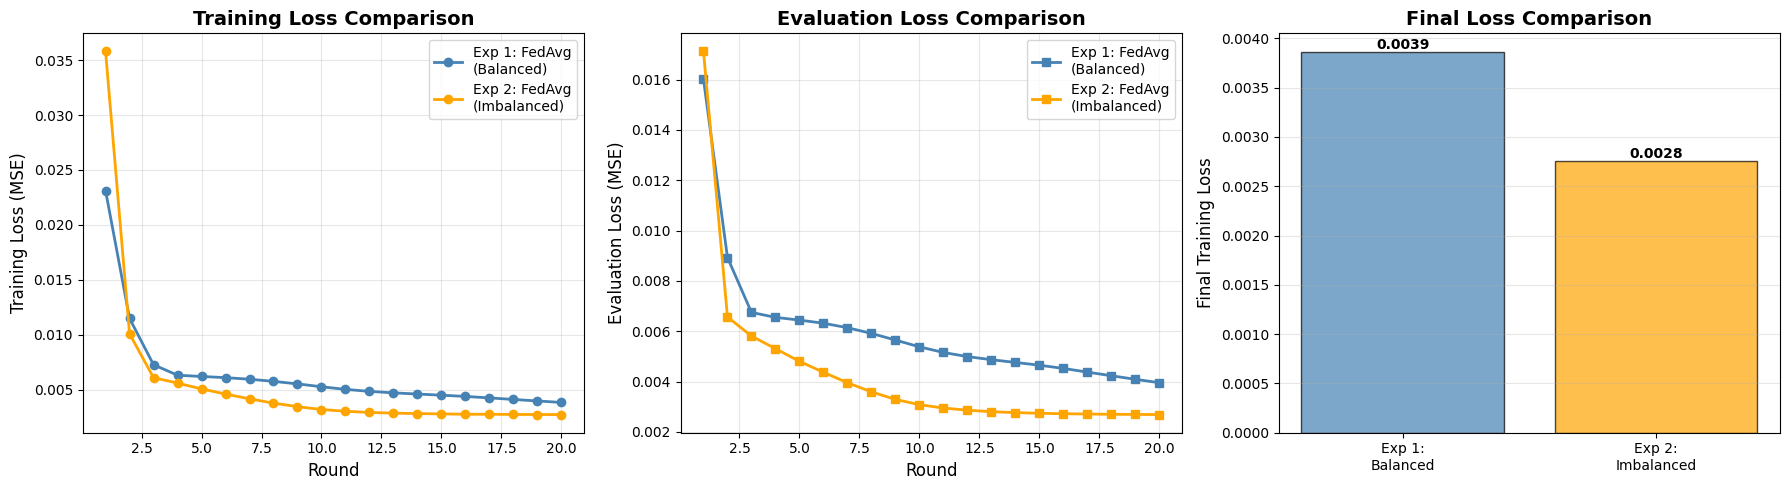


📋 SUMMARY TABLE
Experiment                     Final Train Loss     Final Eval Loss     
----------------------------------------------------------------------
Exp 1: FedAvg (Balanced)       0.003859             0.003954            
Exp 2: FedAvg (Imbalanced)     0.002755             0.002687            

� Performance difference (Exp 2 vs Exp 1): -28.59%

✅ Comparison completed!


(pid=gcs_server) [2025-11-21 11:02:54,467 E 80278 5134317] (gcs_server) gcs_server.cc:302: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(raylet) [2025-11-21 11:02:54,788 E 80282 5134417] (raylet) main.cc:975: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(raylet) [2025-11-21 11:02:54,788 E 80282 5134417] (raylet) main.cc:975: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(ClientAppActor pid=80285) [2025-11-21 11:02:55,509 E 80285 5134937] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metri

In [39]:
print("="*70)
print("🔹 EXPERIMENT 1: FedAvg + Balanced Data (IID)")
print("="*70)

# Configure for balanced distribution
_data_distribution = "balanced"

strategy_balanced = create_strategy()

history_balanced = start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy_balanced,
    client_resources={"num_cpus": 1, "num_gpus": 0.0},
)

# Extract metrics from distributed metrics
train_losses_balanced = [loss for _, loss in history_balanced.metrics_distributed_fit.get("train_loss", [])]
eval_losses_balanced = [loss for _, loss in history_balanced.metrics_distributed.get("eval_loss", [])]

print(f"\n✅ Experiment 1 completed!")
if train_losses_balanced:
    print(f"   Final Train Loss: {train_losses_balanced[-1]:.6f}")
else:
    print(f"   Final Train Loss: N/A")
if eval_losses_balanced:
    print(f"   Final Eval Loss: {eval_losses_balanced[-1]:.6f}")
else:
    print(f"   Final Eval Loss: N/A")
print("="*70)

print("="*70)
print("⚠️  EXPERIMENT 2: FedAvg + Imbalanced Data (Non-IID)")
print("="*70)
print("Data distribution: 20%, 15%, 12%, 10%, 9%, 8%, 8%, 7%, 6%, 5%")
print("="*70)

# Configure for imbalanced distribution
_data_distribution = "imbalanced"

strategy_imbalanced = create_strategy()

history_imbalanced = start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy_imbalanced,
    client_resources={"num_cpus": 1, "num_gpus": 0.0},
)

# Extract metrics from distributed metrics
train_losses_imbalanced = [loss for _, loss in history_imbalanced.metrics_distributed_fit.get("train_loss", [])]
eval_losses_imbalanced = [loss for _, loss in history_imbalanced.metrics_distributed.get("eval_loss", [])]

print(f"\n✅ Experiment 2 completed!")
if train_losses_imbalanced:
    print(f"   Final Train Loss: {train_losses_imbalanced[-1]:.6f}")
else:
    print(f"   Final Train Loss: N/A")
if eval_losses_imbalanced:
    print(f"   Final Eval Loss: {eval_losses_imbalanced[-1]:.6f}")
else:
    print(f"   Final Eval Loss: N/A")
print("="*70)
import matplotlib.pyplot as plt
import numpy as np

print("="*70)
print("📊 COMPARISON OF 2 EXPERIMENTS")
print("="*70)

# Create comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Experiment data
experiments = [
    ("Exp 1: FedAvg\n(Balanced)", train_losses_balanced, eval_losses_balanced, "steelblue"),
    ("Exp 2: FedAvg\n(Imbalanced)", train_losses_imbalanced, eval_losses_imbalanced, "orange"),
]

# Plot 1: Training Loss
ax = axes[0]
for name, train, _, color in experiments:
    if train:
        ax.plot(range(1, len(train) + 1), train, marker='o', label=name, color=color, linewidth=2)
ax.set_xlabel("Round", fontsize=12)
ax.set_ylabel("Training Loss (MSE)", fontsize=12)
ax.set_title("Training Loss Comparison", fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Evaluation Loss
ax = axes[1]
for name, _, eval_loss, color in experiments:
    if eval_loss:
        ax.plot(range(1, len(eval_loss) + 1), eval_loss, marker='s', label=name, color=color, linewidth=2)
ax.set_xlabel("Round", fontsize=12)
ax.set_ylabel("Evaluation Loss (MSE)", fontsize=12)
ax.set_title("Evaluation Loss Comparison", fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Final Loss Comparison (Bar chart)
ax = axes[2]
exp_names = ["Exp 1:\nBalanced", "Exp 2:\nImbalanced"]
final_losses = [
    train_losses_balanced[-1] if train_losses_balanced else 0,
    train_losses_imbalanced[-1] if train_losses_imbalanced else 0,
]
colors_bar = ["steelblue", "orange"]
bars = ax.bar(exp_names, final_losses, color=colors_bar, alpha=0.7, edgecolor='black')
ax.set_ylabel("Final Training Loss", fontsize=12)
ax.set_title("Final Loss Comparison", fontsize=14, fontweight='bold')
ax.grid(True, axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "="*70)
print("📋 SUMMARY TABLE")
print("="*70)
print(f"{'Experiment':<30} {'Final Train Loss':<20} {'Final Eval Loss':<20}")
print("-"*70)

for name, train, eval_loss, _ in experiments:
    train_final = f"{train[-1]:.6f}" if train else "N/A"
    eval_final = f"{eval_loss[-1]:.6f}" if eval_loss else "N/A"
    print(f"{name.replace(chr(10), ' '):<30} {train_final:<20} {eval_final:<20}")

print("="*70)

# Calculate performance difference
if train_losses_balanced and train_losses_imbalanced:
    difference = ((train_losses_imbalanced[-1] - train_losses_balanced[-1]) / train_losses_balanced[-1]) * 100
    print(f"\n� Performance difference (Exp 2 vs Exp 1): {difference:+.2f}%")

print("\n" + "="*70)
print("✅ Comparison completed!")
print("="*70)

### 💡 Key Insights from Experiments

**What We Learned:**

1. **Balanced Data (Exp 1) - Baseline Performance** ✅
   - FedAvg works well when clients have equal data
   - Stable convergence
   - Good final performance
   
2. **Imbalanced Data (Exp 2) - Real-World Challenge** ⚠️
   - Performance may degrade with non-IID data
   - Some clients with less data may overfit
   - Convergence can be slower and less stable
   - Shows the real-world challenges of federated learning

**Recommendations for Production:**

| Scenario | Recommended Strategy | Reason |
|----------|---------------------|---------|
| Balanced data across clients | FedAvg | Simple, efficient, works well |
| Imbalanced data (real-world) | FedAvg or FedProx | Standard approaches for production |
| High data heterogeneity | FedProx or other advanced methods | Better handles non-IID |
| Limited communication | FedAvg | Lower overhead |

**Industrial IoT Applications:**
- 🏭 Predictive maintenance with edge devices
- 🌐 Distributed quality control systems
- 📱 Mobile device anomaly detection
- 🚗 Vehicle fleet health monitoring

**Key Takeaway:**
Data distribution significantly impacts federated learning performance. In real-world deployments, understanding your data distribution is critical for successful model training.

### 9.3. Comparison of 2 Experiments 📊

Compare the performance of both experiments to understand:
1. How data distribution affects FedAvg performance
2. The impact of balanced vs imbalanced data in federated learning

### 9.2. Experiment 2: FedAvg + Imbalanced Data (Non-IID) ⚠️

**Scenario:** Clients have different amounts of data:
- Client 0: 20%, Client 1: 15%, Client 2: 12%, Client 3: 10%, Client 4: 9%
- Client 5: 8%, Client 6: 8%, Client 7: 7%, Client 8: 6%, Client 9: 5%

This simulates real-world federated learning where some nodes collect more data than others.

## 10. Model Evaluation 🎯

Evaluate the best performing model for bearing anomaly detection.

Based on the experiments, we'll use the model with the best performance (likely **FedAdam with imbalanced data** or **FedAvg with balanced data**).

### 💡 Giải Thích: Tại Sao Dùng MSE và Cách Phát Hiện Bất Thường?

#### 🤔 **Câu hỏi: Tại sao cần tính MSE?**

**MSE (Mean Squared Error)** đo lường **sự khác biệt** giữa:
- **Input** (giá trị cảm biến gốc)
- **Output** (giá trị model reconstruct)

**Công thức MSE:**
```
MSE = (1/8) × Σ(input_i - output_i)²

Trong đó:
- 8 = số cảm biến (B1_a, B1_b, B2_a, B2_b, B3_a, B3_b, B4_a, B4_b)
- input_i = giá trị cảm biến thứ i
- output_i = giá trị reconstruct thứ i
```

#### 🎯 **MSE Liên Quan Đến Bất Thường Như Thế Nào?**

**Nguyên lý hoạt động:**

1. **Model học từ dữ liệu BÌNH THƯỜNG** (training):
   - Model học "pattern" của bearing hoạt động bình thường
   - VD: B1_a ≈ 0.12, B1_b ≈ 0.15, tương quan giữa các cảm biến...
   
2. **Khi gặp dữ liệu BÌNH THƯỜNG** (testing):
   - Model **NHẬN RA** pattern quen thuộc
   - Reconstruct **CHÍNH XÁC**
   - **MSE THẤP** ✅
   
3. **Khi gặp dữ liệu BẤT THƯỜNG** (testing):
   - Model **KHÔNG NHẬN RA** pattern này (chưa học bao giờ)
   - Reconstruct **SAI LỆCH**
   - **MSE CAO** ❌

---

#### 📊 **Ví Dụ Cụ Thể:**

**Case 1: Mẫu Bình Thường**
```
Input:  [0.12, 0.15, 0.11, 0.13, 0.14, 0.12, 0.10, 0.13]
Output: [0.12, 0.15, 0.11, 0.13, 0.14, 0.12, 0.10, 0.13]
        ↓
MSE = ((0.12-0.12)² + (0.15-0.15)² + ... ) / 8 = 0.0001
      ↓
✅ MSE THẤP → BÌNH THƯỜNG
```

**Case 2: Mẫu Bất Thường (Cảm biến lỗi)**
```
Input:  [1.20, 0.15, 0.11, 0.13, 0.14, 0.12, 0.10, 0.13]  ← B1_a = 1.20 (quá cao!)
Output: [0.18, 0.15, 0.11, 0.13, 0.14, 0.12, 0.10, 0.13]  ← Model cố reconstruct
        ↓
MSE = ((1.20-0.18)² + (0.15-0.15)² + ... ) / 8 = 0.1302
      ↓
❌ MSE CAO → BẤT THƯỜNG
```

---

#### 🎓 **Tóm Tắt:**

| Tình Huống | Pattern | Model Reconstruct | MSE | Kết Luận |
|------------|---------|-------------------|-----|----------|
| **Bình thường** | Model đã học | Chính xác ✅ | **Thấp** (< threshold) | ✅ Normal |
| **Bất thường** | Model chưa học | Sai lệch ❌ | **Cao** (> threshold) | 🚨 Anomaly |

---

#### 🔧 **Ứng Dụng Thực Tế:**

**Bearing bị hỏng → Rung bất thường → MSE cao → Phát hiện kịp thời!**

1. **Bình thường**: Bearing hoạt động ổn định
   - Rung đều → MSE thấp → Không cảnh báo
   
2. **Bắt đầu hỏng**: Rung bắt đầu thay đổi
   - MSE tăng dần → Cảnh báo sớm
   
3. **Hỏng nặng**: Rung rất bất thường
   - MSE rất cao → Cảnh báo ngay lập tức!

💡 **Ưu điểm**: Không cần nhãn "bất thường", chỉ cần học từ dữ liệu bình thường!

### 🤖 Giải Thích Chi Tiết: Model Reconstruct Làm Gì?

#### 📌 **Câu hỏi: Model training ra để làm gì? Output của nó là gì?**

**Trả lời:** Model là một **Autoencoder** - Bộ mã hóa tự động

---

#### 🏗️ **KIẾN TRÚC MODEL (AUTOENCODER)**

```
INPUT (8 số)  →  ENCODER  →  LATENT (4 số)  →  DECODER  →  OUTPUT (8 số)
   [0.12]         [Nén]        [0.05]          [Giải nén]     [0.121]
   [0.15]         [xuống]      [0.08]          [lại]          [0.149]
   [0.11]         [4 số]       [0.03]          [8 số]         [0.111]
   [0.13]                      [0.06]                         [0.129]
   [0.14]                                                     [0.141]
   [0.12]                                                     [0.119]
   [0.10]                                                     [0.101]
   [0.13]                                                     [0.131]
```

---

#### 🎯 **MODEL RECONSTRUCT LÀM GÌ?**

**Mục đích:** Model cố gắng **TÁI TẠO LẠI** (reconstruct) input từ latent space

**Quá trình:**

1. **ENCODER (Mã hóa):**
   - Nhận 8 số input
   - Nén xuống 4 số (latent representation)
   - Giống như "tóm tắt" thông tin quan trọng nhất

2. **DECODER (Giải mã):**
   - Nhận 4 số từ latent
   - Giải nén lại thành 8 số output
   - Cố gắng **TÁI TẠO GIỐNG** input ban đầu

---

#### 💡 **OUTPUT CỦA MODEL LÀ GÌ?**

**Output = 8 giá trị cảm biến được model "đoán" (reconstruct)**

**Ví dụ cụ thể:**

```python
# INPUT (Giá trị thật từ cảm biến)
input = [0.12, 0.15, 0.11, 0.13, 0.14, 0.12, 0.10, 0.13]

# MODEL XỬ LÝ
# → Encoder: nén 8 số → 4 số
# → Decoder: giải nén 4 số → 8 số

# OUTPUT (Giá trị model tái tạo)
output = [0.121, 0.149, 0.111, 0.129, 0.141, 0.119, 0.101, 0.131]
```

**Output chính là 8 giá trị cảm biến được model "tái tạo" từ latent representation!**

---

#### 🔍 **TẠI SAO CÓ THỂ DÙNG OUTPUT ĐỂ TÍNH MSE?**

**Lý do:**

1. **INPUT = Giá trị THẬT** (từ cảm biến)
2. **OUTPUT = Giá trị model TÁI TẠO** (từ học tập)

**MSE đo "độ giống nhau":**
```
MSE = So sánh INPUT (thật) vs OUTPUT (tái tạo)
```

**Nếu giống nhau → MSE THẤP → Model đã học tốt pattern này → BÌNH THƯỜNG ✅**

**Nếu khác nhau → MSE CAO → Model chưa gặp pattern này → BẤT THƯỜNG ❌**

---

#### 🎓 **ANALOGIE (So sánh dễ hiểu):**

**Giống như học vẽ:**

1. **Training (Học):**
   - Bạn học vẽ chân dung người bình thường
   - Xem nhiều ảnh người bình thường
   - Não bạn ghi nhớ "pattern" của khuôn mặt bình thường

2. **Testing (Kiểm tra):**
   - Cho bạn 1 ảnh
   - Bạn cố gắng vẽ lại (reconstruct)
   
   **Case 1:** Ảnh người bình thường
   - Bạn vẽ giống → **MSE THẤP** → Bình thường ✅
   
   **Case 2:** Ảnh người ngoài hành tinh
   - Bạn vẽ không giống (vì chưa gặp) → **MSE CAO** → Bất thường ❌

---

#### 📊 **QUY TRÌNH HOÀN CHỈNH:**

```
TRAINING (Học từ dữ liệu bình thường):
Dữ liệu bình thường → Model học pattern → Học cách reconstruct tốt

TESTING (Phát hiện bất thường):
Dữ liệu mới → Model reconstruct → So sánh Input vs Output → Tính MSE
                                                                ↓
                                    MSE thấp → Pattern quen → ✅ Bình thường
                                    MSE cao → Pattern lạ → ❌ Bất thường
```

---

#### 🎯 **TÓM TẮT:**

| Thành phần | Là gì? | Ví dụ giá trị |
|------------|--------|---------------|
| **INPUT** | 8 giá trị cảm biến THẬT | [0.12, 0.15, 0.11, 0.13, 0.14, 0.12, 0.10, 0.13] |
| **LATENT** | 4 số "tóm tắt" (nén) | [0.05, 0.08, 0.03, 0.06] |
| **OUTPUT** | 8 giá trị model TÁI TẠO | [0.121, 0.149, 0.111, 0.129, 0.141, 0.119, 0.101, 0.131] |
| **MSE** | Độ khác biệt INPUT vs OUTPUT | 0.0001 (bình thường) hoặc 0.5234 (bất thường) |

💡 **Kết luận:** Model OUTPUT ra 8 số (tái tạo input), dùng OUTPUT này so với INPUT để tính MSE!

#### Test Case

Lấy một mẫu từ test set (đã biết là bình thường)
# Scenario 1: Một cảm biến bị lỗi (B1_a có giá trị bất thường cao)

# Scenario 2: Toàn bộ bearing rung quá mạnh (tất cả giá trị tăng)
# Scenario 3: Giá trị âm (lỗi phần cứng/sensor)

In [ ]:
# Tính ngưỡng từ dữ liệu test
threshold_95 = np.percentile(all_errors, 95)
threshold_mean_2std = np.mean(all_errors) + 2 * np.std(all_errors)

print("=" * 80)
print("📊 NGƯỠNG PHÁT HIỆN BẤT THƯỜNG (ANOMALY THRESHOLD)")
print("=" * 80)
print(f"\n1️⃣  95th Percentile: {threshold_95:.6f}")
print(f"2️⃣  Mean + 2×Std:    {threshold_mean_2std:.6f}")
print(f"\nℹ️  Chọn ngưỡng: {threshold_95:.6f} (95th percentile)")
print(f"\n🎯 QUY TẮC:")
print(f"   ✅ Error < {threshold_95:.6f} → BÌNH THƯỜNG (Normal)")
print(f"   ❌ Error > {threshold_95:.6f} → BẤT THƯỜNG (Anomaly)")
print("=" * 80)

# Sử dụng threshold_95 làm ngưỡng chính
anomaly_threshold = threshold_95
# Hàm để test một mẫu cảm biến
def test_bearing_sample(sensor_values, model, threshold, device, sample_name="Test Sample"):
    """
    Test một mẫu cảm biến và phát hiện bất thường.

    Args:
        sensor_values: Array 8 giá trị cảm biến [B1_a, B1_b, B2_a, B2_b, B3_a, B3_b, B4_a, B4_b]
        model: Trained autoencoder model
        threshold: Ngưỡng phát hiện bất thường
        device: Device (cpu/cuda)
        sample_name: Tên mẫu để hiển thị

    Returns:
        error: Reconstruction error (MSE)
        is_anomaly: True nếu bất thường, False nếu bình thường
    """
    # Chuyển sang tensor
    x = torch.tensor(sensor_values, dtype=torch.float32).unsqueeze(0).to(device)

    # Predict (reconstruct)
    model.eval()
    with torch.no_grad():
        reconstructed = model(x)

    # Tính error
    x_np = x.cpu().numpy()[0]
    recon_np = reconstructed.cpu().numpy()[0]
    error = np.mean((x_np - recon_np) ** 2)

    # Phát hiện bất thường
    is_anomaly = error > threshold

    # Hiển thị kết quả
    print("\n" + "=" * 80)
    print(f"🔍 KẾT QUẢ KIỂM TRA: {sample_name}")
    print("=" * 80)

    sensor_names = ['B1_a', 'B1_b', 'B2_a', 'B2_b', 'B3_a', 'B3_b', 'B4_a', 'B4_b']

    print("\n📥 INPUT (Giá trị cảm biến đầu vào):")
    for i, (name, val) in enumerate(zip(sensor_names, x_np)):
        print(f"   {name}: {val:8.4f}", end="")
        if (i + 1) % 4 == 0:
            print()

    print("\n📤 OUTPUT (Model reconstruct):")
    for i, (name, val) in enumerate(zip(sensor_names, recon_np)):
        print(f"   {name}: {val:8.4f}", end="")
        if (i + 1) % 4 == 0:
            print()

    print(f"\n📊 RECONSTRUCTION ERROR:")
    print(f"   MSE:  {error:.6f}")
    print(f"   RMSE: {np.sqrt(error):.6f}")
    print(f"   Threshold: {threshold:.6f}")

    print(f"\n🎯 Dự ĐOÁN:")
    if is_anomaly:
        print(f"   🚨 BẤT THƯỜNG (ANOMALY DETECTED!)")
        print(f"   ⚠️  Error ({error:.6f}) > Threshold ({threshold:.6f})")
        print(f"   💡 Cảnh báo: Cảm biến có dấu hiệu bất thường, cần kiểm tra!")
    else:
        print(f"   ✅ BÌNH THƯỜNG (NORMAL)")
        print(f"   ✓  Error ({error:.6f}) < Threshold ({threshold:.6f})")
        print(f"   💡 Hệ thống hoạt động bình thường")

    print("=" * 80)

    return error, is_anomaly

print("✅ Hàm test_bearing_sample() đã sẵn sàng!")
# Test với mẫu bình thường từ test set
normal_sample = num_df.iloc[100].values  # Lấy mẫu thứ 100

error_normal, is_anomaly_normal = test_bearing_sample(
    sensor_values=normal_sample,
    model=final_model,
    threshold=anomaly_threshold,
    device=device,
    sample_name="Mẫu Bình Thường (từ test set)"
)
# Scenario 1: Một cảm biến bị lỗi (B1_a có giá trị bất thường cao)
anomaly_sample_1 = normal_sample.copy()
anomaly_sample_1[0] = anomaly_sample_1[0] * 10  # Tăng B1_a lên 10 lần

error_anomaly_1, is_anomaly_1 = test_bearing_sample(
    sensor_values=anomaly_sample_1,
    model=final_model,
    threshold=anomaly_threshold,
    device=device,
    sample_name="Scenario 1: Cảm biến B1_a lỗi (giá trị cao bất thường)"
)

# Scenario 2: Toàn bộ bearing rung quá mạnh (tất cả giá trị tăng)
anomaly_sample_2 = normal_sample.copy() * 3  # Tăng tất cả lên 3 lần

error_anomaly_2, is_anomaly_2 = test_bearing_sample(
    sensor_values=anomaly_sample_2,
    model=final_model,
    threshold=anomaly_threshold,
    device=device,
    sample_name="Scenario 2: Bearing rung mạnh (tất cả cảm biến tăng)"
)
# Scenario 3: Giá trị âm (lỗi phần cứng/sensor)
anomaly_sample_3 = normal_sample.copy()
anomaly_sample_3[2] = -0.5  # B2_a có giá trị âm (không hợp lệ)
anomaly_sample_3[3] = -0.3  # B2_b có giá trị âm

error_anomaly_3, is_anomaly_3 = test_bearing_sample(
    sensor_values=anomaly_sample_3,
    model=final_model,
    threshold=anomaly_threshold,
    device=device,
    sample_name="Scenario 3: Lỗi phần cứng (giá trị âm không hợp lệ)"
)
# So sánh tất cả các test cases
print("\n" + "=" * 80)
print("📊 TỔNG KẾT SO SÁNH TẤT CẢ TEST CASES")
print("=" * 80)

test_results = [
    ("Mẫu Bình Thường", error_normal, is_anomaly_normal),
    ("Scenario 1: Cảm biến lỗi", error_anomaly_1, is_anomaly_1),
    ("Scenario 2: Rung mạnh", error_anomaly_2, is_anomaly_2),
    ("Scenario 3: Giá trị âm", error_anomaly_3, is_anomaly_3)
]

print(f"\n{'STT':<5} {'Tên Test Case':<30} {'Error (MSE)':<15} {'Kết Quả':<20}")
print("-" * 80)

for i, (name, error, is_anomaly) in enumerate(test_results, 1):
    status = "🚨 BẤT THƯỜNG" if is_anomaly else "✅ BÌNH THƯỜNG"
    print(f"{i:<5} {name:<30} {error:<15.6f} {status:<20}")

print("-" * 80)
print(f"\n🎯 Ngưỡng (Threshold): {anomaly_threshold:.6f}")
print(f"\n📈 Phân tích:")
print(f"   • Số mẫu bình thường: {sum(1 for _, _, a in test_results if not a)}")
print(f"   • Số mẫu bất thường: {sum(1 for _, _, a in test_results if a)}")
print(f"   • Error thấp nhất: {min(e for _, e, _ in test_results):.6f}")
print(f"   • Error cao nhất: {max(e for _, e, _ in test_results):.6f}")

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))

names = [name for name, _, _ in test_results]
errors = [error for _, error, _ in test_results]
colors = ['green' if not is_anom else 'red' for _, _, is_anom in test_results]

bars = ax.bar(range(len(names)), errors, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add threshold line
ax.axhline(y=anomaly_threshold, color='orange', linestyle='--', linewidth=2,
          label=f'Threshold: {anomaly_threshold:.6f}')

# Add value labels on bars
for i, (bar, error) in enumerate(zip(bars, errors)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{error:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Test Case', fontsize=12, fontweight='bold')
ax.set_ylabel('Reconstruction Error (MSE)', fontsize=12, fontweight='bold')
ax.set_title('So Sánh Reconstruction Error: Bình Thường vs Bất Thường',
            fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=15, ha='right', fontsize=10)
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

# Add color legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.7, label='✅ Bình thường'),
    Patch(facecolor='red', alpha=0.7, label='🚨 Bất thường')
]
ax.legend(handles=legend_elements + [plt.Line2D([0], [0], color='orange', linestyle='--',
         linewidth=2, label=f'Threshold: {anomaly_threshold:.6f}')],
         fontsize=10, loc='upper left')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("✅ Hoàn thành phân tích anomaly detection!")
print("=" * 80)

## 12. Save Final Model 💾

Save the trained global model for future use.

In [ ]:
# Save model state dict
model_path = "final_bearing_autoencoder.pt"
torch.save(final_model.state_dict(), model_path)
print(f"✅ Model saved to: {model_path}")

# Download the model (in Colab)
try:
    from google.colab import files
    files.download(model_path)
    print(f"📥 Model downloaded to your computer!")
except ImportError:
    print("Not running in Colab, model saved locally.")

# Test loading the model
loaded_model = BearingAutoencoder()
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()
print("✅ Model successfully loaded and ready for inference!")